In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
base_path = './drive/My Drive/Colab Notebooks/Speech Denoising/Data/'

In [76]:
!pip install librosa

In [0]:
import librosa

In [0]:
s, sr=librosa.load(base_path + 'train_clean_male.wav', sr=None)
train_clean=librosa.stft(s, n_fft=1024, hop_length=512).T
sn, sr=librosa.load(base_path + 'train_dirty_male.wav', sr=None)
train_dirty=librosa.stft(sn, n_fft=1024, hop_length=512).T

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
train_clean.shape

(2459, 513)

(2459, 513)

(2459, 513)

In [0]:
import tensorflow as tf

In [0]:
train_clean_val = np.abs(train_clean)
train_dirty_val = np.abs(train_dirty)

In [83]:
print(f'min(train_clean_val) = {np.min(train_clean_val)}, max(train_clean_val) = {np.max(train_clean_val)}')
print(f'min(train_dirty_val) = {np.min(train_dirty_val)}, max(train_dirty_val) = {np.max(train_dirty_val)}')

min(train_clean_val) = 2.724569583278935e-07, max(train_clean_val) = 31.574600219726562
min(train_dirty_val) = 3.297913409028297e-08, max(train_dirty_val) = 31.603910446166992
min(train_clean_val) = 2.724569583278935e-07, max(train_clean_val) = 31.574600219726562
min(train_dirty_val) = 3.297913409028297e-08, max(train_dirty_val) = 31.603910446166992
min(train_clean_val) = 2.724569583278935e-07, max(train_clean_val) = 31.574600219726562
min(train_dirty_val) = 3.297913409028297e-08, max(train_dirty_val) = 31.603910446166992


In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_dirty_val, train_clean_val, test_size=0.2)

In [0]:
# Build neural network
X = tf.placeholder(dtype='float', shape=[None, 513])
y = tf.placeholder(dtype='float', shape=[None, 513])

in_units = 513
h1_units = 450
h2_units = 300
h3_units = 300
h4_units = 450
out_units = 513

# He initializer: mean = 0.0, stddev = sqrt(2/#in_nodes)
weights = {
    'w1': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[in_units, h1_units], mean=0.0, stddev=np.sqrt(2/in_units))),
    'w2': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[h1_units, h2_units], mean=0.0, stddev=np.sqrt(2/h1_units))),
    'w3': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[h2_units, h3_units], mean=0.0, stddev=np.sqrt(2/h2_units))),
    'w4': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[h3_units, h4_units], mean=0.0, stddev=np.sqrt(2/h3_units))),
    'out': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[h4_units, out_units], mean=0.0, stddev=np.sqrt(2/h4_units))),
}

bias_initial_value = 0.01
biases = {
    'b1': tf.Variable(initial_value=tf.ones([h1_units]) * bias_initial_value),
    'b2': tf.Variable(initial_value=tf.ones([h2_units]) * bias_initial_value),
    'b3': tf.Variable(initial_value=tf.ones([h3_units]) * bias_initial_value),
    'b4': tf.Variable(initial_value=tf.ones([h4_units]) * bias_initial_value),
    'out': tf.Variable(initial_value=tf.ones([out_units]) * bias_initial_value)
}

In [0]:
beta = 0.000005

z1 = tf.add(tf.matmul(X, weights['w1']), biases['b1'])
a1 = tf.nn.relu(z1)

z2 = tf.add(tf.matmul(a1, weights['w2']), biases['b2'])
a2 = tf.nn.relu(z2)

z3 = tf.add(tf.matmul(a2, weights['w3']), biases['b3'])
a3 = tf.nn.relu(z3)

z4 = tf.add(tf.matmul(a2, weights['w4']), biases['b4'])
a4 = tf.nn.relu(z4)

logits = tf.add(tf.matmul(a4, weights['out']), biases['out'])
output = tf.nn.relu(logits)

regularizers = tf.nn.l2_loss(weights['w1']) + tf.nn.l2_loss(weights['w2']) + tf.nn.l2_loss(weights['w3']) + tf.nn.l2_loss(weights['w4']) + tf.nn.l2_loss(weights['out'])
mse = tf.losses.mean_squared_error(labels=y, predictions=output)
loss = tf.reduce_mean(mse + beta * regularizers)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

train = optimizer.minimize(loss=loss)

# calculate accuracy
correct = tf.equal(tf.argmax(input=logits, axis=1), tf.argmax(input=y, axis=1))
accuracy = tf.reduce_mean(tf.cast(dtype='float', x=correct))

init = tf.global_variables_initializer()

In [126]:
batch_size = 1000
total_samples = X_train.shape[0]

train_acc, test_acc = [], []
train_loss, test_loss = [], []
train_mse, test_mse = [], []

sess = tf.Session()
  
sess.run(init)
for epoch in range(1, 10001):
  for itr in range(total_samples//batch_size + 1):
    start_idx = itr * batch_size
    end_idx = min((itr + 1) * batch_size, total_samples)
    batch_x, batch_y = X_train[start_idx:end_idx, :], y_train[start_idx:end_idx, :]
    sess.run(train, feed_dict={X: batch_x, y: batch_y})
    
  if epoch % 10 == 0:
    trls, trac, trmse = sess.run([loss, accuracy, mse], feed_dict={X: X_train, y: y_train})
    tsls, tsac, tsmse = sess.run([loss, accuracy, mse], feed_dict={X: X_test, y: y_test})
    
    train_acc.append(trac)
    train_loss.append(trls)
    train_mse.append(trmse)
    
    test_acc.append(tsac)
    test_loss.append(tsls)
    test_mse.append(tsmse)
    
    if epoch % 1000 == 0:
      print(f'Epoch:{epoch}')
      print(f'Train set:\tLoss:{trls:.4f},\tAccuracy:{trac:.4f}\tMSE:{trmse:.4f}')
      print(f'Test set:\tLoss:{tsls:.4f},\tAccuracy:{tsac:.4f}\tMSE:{tsmse:.4f}\n')

Epoch:1000
Train set:	Loss:0.0035,	Accuracy:0.5547	MSE:0.0014
Test set:	Loss:0.0072,	Accuracy:0.4919	MSE:0.0050

Epoch:2000
Train set:	Loss:0.0025,	Accuracy:0.5684	MSE:0.0011
Test set:	Loss:0.0060,	Accuracy:0.5000	MSE:0.0046

Epoch:3000
Train set:	Loss:0.0023,	Accuracy:0.5562	MSE:0.0010
Test set:	Loss:0.0058,	Accuracy:0.4837	MSE:0.0045

Epoch:4000
Train set:	Loss:0.0022,	Accuracy:0.5648	MSE:0.0010
Test set:	Loss:0.0058,	Accuracy:0.4959	MSE:0.0046

Epoch:5000
Train set:	Loss:0.0022,	Accuracy:0.5704	MSE:0.0009
Test set:	Loss:0.0058,	Accuracy:0.4959	MSE:0.0045

Epoch:6000
Train set:	Loss:0.0021,	Accuracy:0.5689	MSE:0.0009
Test set:	Loss:0.0058,	Accuracy:0.4959	MSE:0.0046

Epoch:7000
Train set:	Loss:0.0021,	Accuracy:0.5663	MSE:0.0009
Test set:	Loss:0.0058,	Accuracy:0.4858	MSE:0.0046

Epoch:8000
Train set:	Loss:0.0021,	Accuracy:0.5740	MSE:0.0009
Test set:	Loss:0.0058,	Accuracy:0.4878	MSE:0.0047

Epoch:9000
Train set:	Loss:0.0021,	Accuracy:0.5719	MSE:0.0009
Test set:	Loss:0.0059,	Accuracy:0.

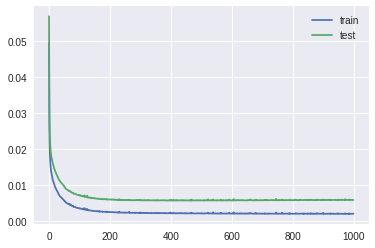

In [128]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])

In [0]:
# save_audio(test1_dirty.T, test1_dirty_val.T, test1_clean_val.T, base_path+'output.wav')

In [0]:
def clean_audio(filename, out_filename):
    print(filename, out_filename)
    s, sr = librosa.load(filename, sr=None)
    dirty = librosa.stft(s, n_fft=1024, hop_length=512).T
    dirty_val = np.abs(dirty)
    clean_val = sess.run(output, feed_dict={X: dirty_val})
    
    result = np.multiply(np.divide(dirty.T, dirty_val.T), clean_val.T)
    sh_test = librosa.istft(result, hop_length=512)
    librosa.output.write_wav(out_filename, sh_test, sr)

In [130]:
clean_audio(base_path + 'test_x_01.wav', base_path + 'test_x_01_cleaned.wav')

./drive/My Drive/Colab Notebooks/Speech Denoising/Data/test_x_01.wav ./drive/My Drive/Colab Notebooks/Speech Denoising/Data/test_x_01_cleaned.wav


In [131]:
clean_audio(base_path + 'test_x_02.wav', base_path + 'test_x_02_cleaned.wav')

./drive/My Drive/Colab Notebooks/Speech Denoising/Data/test_x_02.wav ./drive/My Drive/Colab Notebooks/Speech Denoising/Data/test_x_02_cleaned.wav
